In [ ]:
# Install necessary libraries
!pip install tensorflow
!pip install keras
!pip install scikit-learn

In [ ]:

# Import libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os
import matplotlib.pyplot as plt

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define dataset paths
data_path = '/content/drive/MyDrive/Dataset/Alzheimers-ADNI'
train_path = os.path.join(data_path, 'train')
test_path = os.path.join(data_path, 'test')

In [ ]:

# Define image dimensions and batch size
img_size = (224, 224)
batch_size = 32

In [ ]:
# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [ ]:
# Validation set without data augmentation
valid_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Load the training set
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 1101 images belonging to 5 classes.


In [ ]:
# Load the validation set
valid_generator = valid_datagen.flow_from_directory(
    test_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 195 images belonging to 5 classes.


In [ ]:
# Define Xception with Transfer Learning
base_model_xception = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_xception = models.Sequential()
model_xception.add(base_model_xception)
model_xception.add(layers.GlobalAveragePooling2D())
model_xception.add(layers.Dense(5, activation='softmax'))

83683744/83683744 [==============================] - 0s 0us/step


In [ ]:
# Freeze base model layers
for layer in base_model_xception.layers:
    layer.trainable = False


In [ ]:
# Compile the model
model_xception.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model with Transfer Learning
epochs_transfer_learning = 10
history_transfer_learning = model_xception.fit(train_generator, epochs=epochs_transfer_learning, validation_data=valid_generator)

Epoch 1/10
35/35 [==============================] - 25s 702ms/step - loss: 1.1405 - accuracy: 0.5286 - val_loss: 4.6372 - val_accuracy: 0.4410
Epoch 2/10
35/35 [==============================] - 23s 659ms/step - loss: 1.1084 - accuracy: 0.5459 - val_loss: 2.7820 - val_accuracy: 0.3538
Epoch 3/10
35/35 [==============================] - 25s 694ms/step - loss: 1.0301 - accuracy: 0.5613 - val_loss: 3.1919 - val_accuracy: 0.3282
Epoch 4/10
35/35 [==============================] - 25s 695ms/step - loss: 0.9537 - accuracy: 0.6240 - val_loss: 2.3620 - val_accuracy: 0.2615
Epoch 5/10
35/35 [==============================] - 24s 680ms/step - loss: 0.8806 - accuracy: 0.6322 - val_loss: 2.5725 - val_accuracy: 0.2872
Epoch 6/10
35/35 [==============================] - 24s 676ms/step - loss: 0.7624 - accuracy: 0.7003 - val_loss: 2.0422 - val_accuracy: 0.4410
Epoch 7/10
35/35 [==============================] - 24s 673ms/step - loss: 0.7338 - accuracy: 0.7012 - val_loss: 2.3362 - val_accuracy: 0.4103

In [ ]:
# Fine-tune the model
for layer in base_model_xception.layers:
    layer.trainable = True


In [ ]:
# Compile the model for fine-tuning
model_xception.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model with Fine-Tuning
epochs_fine_tuning = 5
history_fine_tuning = model_xception.fit(train_generator, epochs=epochs_fine_tuning, validation_data=valid_generator)

Epoch 1/5
35/35 [==============================] - 415s 11s/step - loss: 1.4294 - accuracy: 0.4541 - val_loss: 2.0819 - val_accuracy: 0.4821
Epoch 2/5
35/35 [==============================] - 24s 664ms/step - loss: 1.3436 - accuracy: 0.4623 - val_loss: 3.1301 - val_accuracy: 0.4205
Epoch 3/5
35/35 [==============================] - 24s 672ms/step - loss: 1.3135 - accuracy: 0.4632 - val_loss: 2.3871 - val_accuracy: 0.4667
Epoch 4/5
35/35 [==============================] - 23s 656ms/step - loss: 1.2679 - accuracy: 0.4932 - val_loss: 1.6397 - val_accuracy: 0.4667
Epoch 5/5
35/35 [==============================] - 24s 682ms/step - loss: 1.1892 - accuracy: 0.5177 - val_loss: 1.9099 - val_accuracy: 0.4410


In [ ]:
# Save the model
model_xception.save('/content/drive/MyDrive/xception_transfer_fine_tuning.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Evaluate the model on test set
test_generator = valid_datagen.flow_from_directory(
    test_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important: set shuffle to False for correct evaluation
)


Found 195 images belonging to 5 classes.


In [ ]:
# Evaluate the model
eval_results = model_xception.evaluate(test_generator)
print("Test Accuracy:", eval_results[1])

7/7 [==============================] - 1s 157ms/step - loss: 1.9099 - accuracy: 0.4410
Test Accuracy: 0.44102564454078674


In [ ]:
# Get predictions
predictions = model_xception.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

7/7 [==============================] - 2s 147ms/step


In [ ]:
# Print classification report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes))

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.15      0.24        26
           1       0.53      0.74      0.62        87
           2       0.27      0.50      0.35        36
           3       0.00      0.00      0.00        11
           4       0.00      0.00      0.00        35

    accuracy                           0.44       195
   macro avg       0.26      0.28      0.24       195
weighted avg       0.35      0.44      0.37       195



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(true_classes, predicted_classes))

Confusion Matrix:
[[ 4 10 12  0  0]
 [ 1 64 22  0  0]
 [ 1 17 18  0  0]
 [ 1  6  4  0  0]
 [ 1 24 10  0  0]]


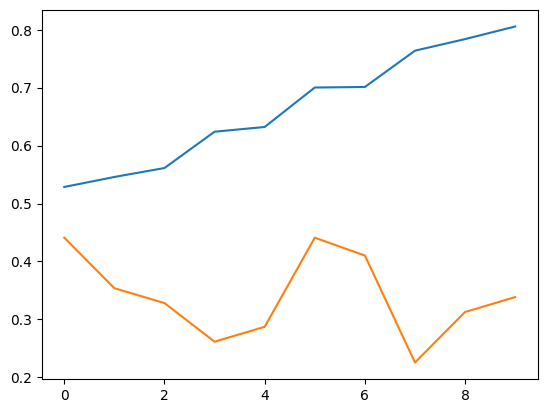

In [ ]:
# Plot training and validation accuracy vs epochs for Transfer Learning
plt.plot(history_transfer_learning.history['accuracy'], label='Training Accuracy (Transfer Learning)')
plt.plot(history_transfer_learning.history['val_accuracy'], label='Validation Accuracy (Transfer Learning)')

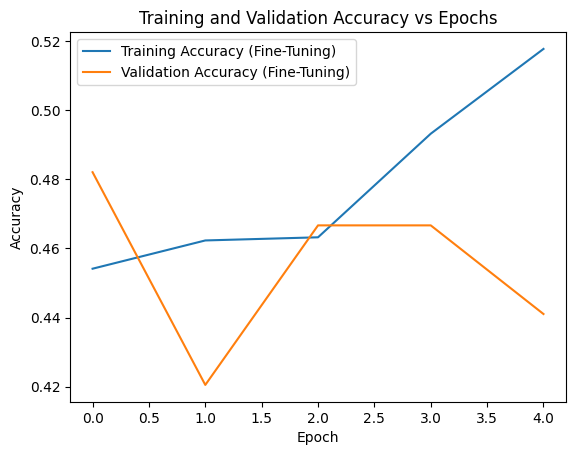

In [ ]:
# Plot training and validation accuracy vs epochs for Fine-Tuning
plt.plot(history_fine_tuning.history['accuracy'], label='Training Accuracy (Fine-Tuning)')
plt.plot(history_fine_tuning.history['val_accuracy'], label='Validation Accuracy (Fine-Tuning)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy vs Epochs')
plt.show()

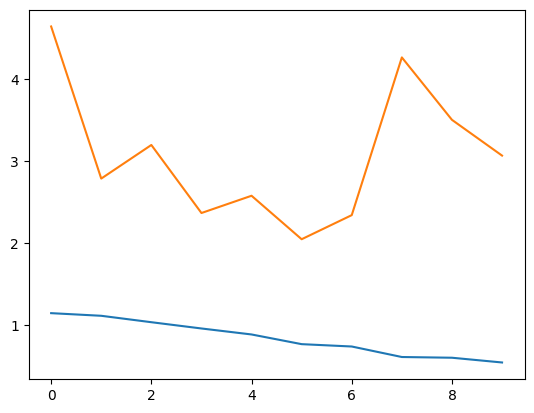

In [ ]:
# Plot training and validation loss vs epochs for Transfer Learning
plt.plot(history_transfer_learning.history['loss'], label='Training Loss (Transfer Learning)')
plt.plot(history_transfer_learning.history['val_loss'], label='Validation Loss (Transfer Learning)')

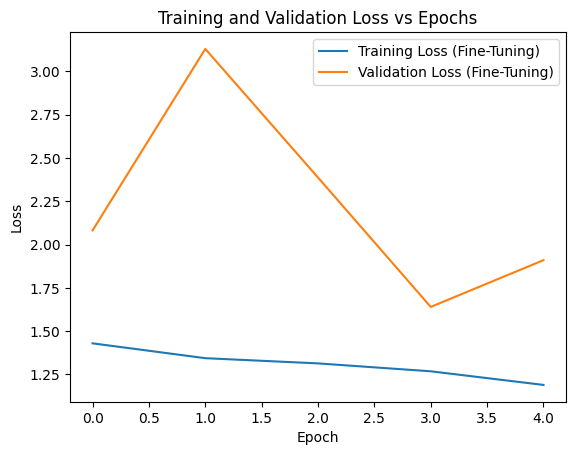

In [ ]:
# Plot training and validation loss vs epochs for Fine-Tuning
plt.plot(history_fine_tuning.history['loss'], label='Training Loss (Fine-Tuning)')
plt.plot(history_fine_tuning.history['val_loss'], label='Validation Loss (Fine-Tuning)')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss vs Epochs')
plt.show()